In [1]:
# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pickle
import numpy as np
import bayesflow as beef
import tensorflow as tf
from tensorflow.keras.backend import clear_session

import sys
sys.path.append("../")
from experiment import ModelComparisonExperiment

/Users/lukas/opt/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [32]:
NUM_MODELS = 4
ENSEMBLE_SIZE = 10
SIMULATION_PER_MODEL = 10000
CHUNCK_SIZE = 200
MODEL_NAMES = [
    'Random walk DDM', 'Mixture random walk DDM',
    'Levy flight DDM', 'Regime switching DDM'
    ]

with open('../data/validation_data.pkl', 'rb') as f:
    validation_data = pickle.load(f)

configurator = beef.configuration.DefaultModelComparisonConfigurator(NUM_MODELS)

model_indices = tf.one_hot(np.tile(np.repeat(
    [0, 1, 2, 3], CHUNCK_SIZE), int((SIMULATION_PER_MODEL/CHUNCK_SIZE))), NUM_MODELS
    )

def get_model_probablities(trainer):
    model_probs = np.zeros((int(SIMULATION_PER_MODEL*NUM_MODELS), NUM_MODELS))
    chunks = np.arange(0, SIMULATION_PER_MODEL+1, CHUNCK_SIZE)
    for i in range(len(chunks)-1):
        sim_1 = {'sim_data': validation_data['model_outputs'][0]['sim_data'][chunks[i]:chunks[i+1]]}
        sim_2 = {'sim_data': validation_data['model_outputs'][1]['sim_data'][chunks[i]:chunks[i+1]]}
        sim_3 = {'sim_data': validation_data['model_outputs'][2]['sim_data'][chunks[i]:chunks[i+1]]}
        sim_4 = {'sim_data': validation_data['model_outputs'][3]['sim_data'][chunks[i]:chunks[i+1]]}

        tmp_validation_data = {
            'model_outputs': [sim_1, sim_2, sim_3, sim_4],
            'model_indices': validation_data['model_indices']
        }

        tmp_validation_data_configured = configurator(tmp_validation_data)
        with tf.device('/cpu:0'):
            model_probs[(chunks[i]*NUM_MODELS):(chunks[i+1]*NUM_MODELS)] = trainer.amortizer.posterior_probs(
                tmp_validation_data_configured
            )
    return model_probs

In [19]:
i = 0
trainer = ModelComparisonExperiment(
        checkpoint_path=f'../checkpoints/ensemble_{i}'
        )

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


INFO:root:Loaded loss history from ../checkpoints/ensemble_0/history_25.pkl.
INFO:root:Networks loaded from ../checkpoints/ensemble_0/ckpt-25


In [20]:
model_probs_per_ensemble = np.zeros((ENSEMBLE_SIZE, SIMULATION_PER_MODEL*NUM_MODELS, NUM_MODELS))

In [58]:
model_probs_per_ensemble[0] = get_model_probablities(trainer)

In [23]:
model_probs = np.zeros((int(SIMULATION_PER_MODEL*NUM_MODELS), NUM_MODELS))
chunks = np.arange(SIMULATION_PER_MODEL+1, CHUNCK_SIZE)
chunks
# for i in range(len(chunks)-1):
#     sim_1 = {'sim_data': validation_data['model_outputs'][0]['sim_data'][chunks[i]:chunks[i+1]]}
#     sim_2 = {'sim_data': validation_data['model_outputs'][1]['sim_data'][chunks[i]:chunks[i+1]]}
#     sim_3 = {'sim_data': validation_data['model_outputs'][2]['sim_data'][chunks[i]:chunks[i+1]]}
#     sim_4 = {'sim_data': validation_data['model_outputs'][3]['sim_data'][chunks[i]:chunks[i+1]]}

#     tmp_validation_data = {
#         'model_outputs': [sim_1, sim_2, sim_3, sim_4],
#         'model_indices': validation_data['model_indices']
#     }

#     tmp_validation_data_configured = configurator(tmp_validation_data)
#     with tf.device('/cpu:0'):
#         model_probs[(chunks[i]*NUM_MODELS):(chunks[i+1]*NUM_MODELS)] = trainer.amortizer.posterior_probs(
#             tmp_validation_data_configured
#         )

array([], dtype=int64)

In [3]:
ENSEMBLE_SIZE = 10

In [ ]:
for i in range(ENSEMBLE_SIZE):
    # initialize trainer
    experiment = ModelComparisonExperiment(
        checkpoint_path=f'checkpoints/ensemble_{i}'
        )
    # read training and validation data
    with open('../data/training_data.pkl', 'rb') as f:
        training_data = pickle.load(f)
    with open('../data/training_validation_data.pkl', 'rb') as f:
        training_validation_data = pickle.load(f)
    # start training
    history = experiment.run(
        training_data=training_data,
        validation_data=training_validation_data
    )

# Validation

In [4]:
with open('../data/validation_data.pkl', 'rb') as f:
    validation_data = pickle.load(f)

In [8]:
validation_data['model_outputs'][3]['sim_data'].shape

(10000, 800, 1)

In [ ]:
configurator = beef.configuration.DefaultModelComparisonConfigurator(4)

In [ ]:
model_probs = np.zeros((40000, 4))
chunks = np.arange(0, 10001, 200)
for i in range(len(chunks)-1):
    sim_1 = {'sim_data': validation_data['model_outputs'][0]['sim_data'][chunks[i]:chunks[i+1]]}
    sim_2 = {'sim_data': validation_data['model_outputs'][1]['sim_data'][chunks[i]:chunks[i+1]]}
    sim_3 = {'sim_data': validation_data['model_outputs'][2]['sim_data'][chunks[i]:chunks[i+1]]}
    sim_4 = {'sim_data': validation_data['model_outputs'][3]['sim_data'][chunks[i]:chunks[i+1]]}
    
    tmp_validation_data = {
        'model_outputs': [sim_1, sim_2, sim_3, sim_4],
        'model_indices': validation_data['model_indices']
    }
    
    tmp_validation_data_configured = configurator(tmp_validation_data)
    with tf.device('/cpu:0'):
        model_probs[(chunks[i]*4):(chunks[i+1]*4)] = experiment.amortizer.posterior_probs(
            tmp_validation_data_configured
        )

In [ ]:
model_indices = tf.one_hot(np.tile(np.repeat([0, 1, 2, 3], 200), 50), 4)

In [ ]:
cal_curves = beef.diagnostics.plot_calibration_curves(
    true_models=model_indices,
    pred_models=model_probs,
    model_names=['Random walk',
                 'Mixture random walk',
                 'Levy flight',
                 'Regime switching'],
    fig_size=(14, 3)
)

In [27]:
model_indices = np.load("model_indices.npy")
model_probs = np.load("model_probs.npy")

In [35]:
MODEL_NAMES= [
    'Random walk DDM', 'Mixture random walk DDM',
    'Levy flight DDM', 'Regime switching DDM'
    ]
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

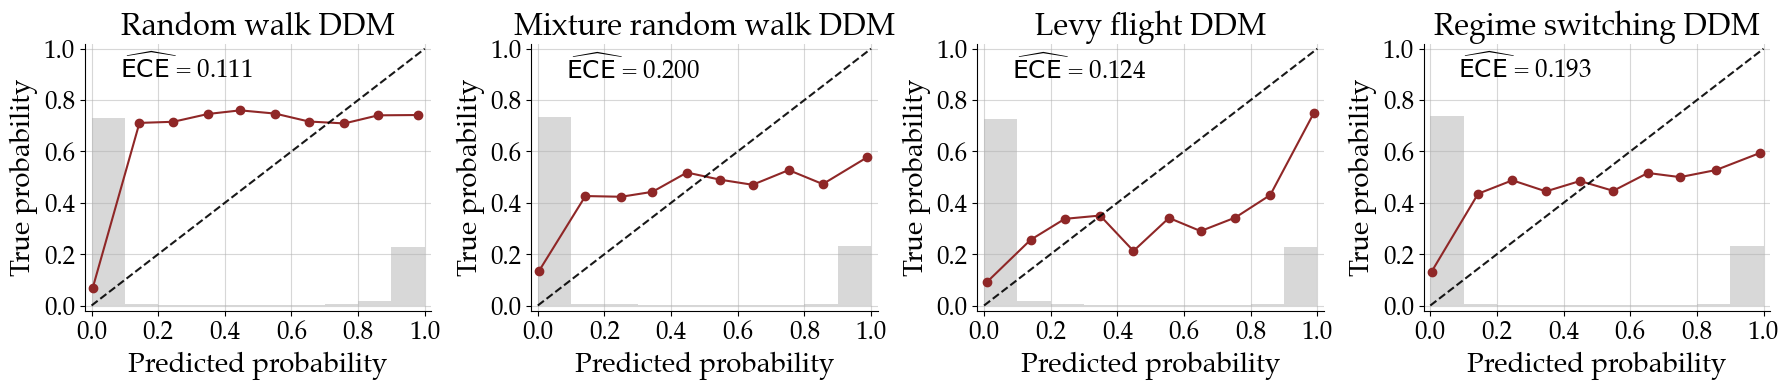

In [45]:
cal_curves = beef.diagnostics.plot_calibration_curves(
    true_models=model_indices,
    pred_models=model_probs,
    model_names=MODEL_NAMES,
    fig_size=(18, 4),
    title_fontsize=22,
    label_fontsize=20,
    tick_fontsize=18,
    legend_fontsize=18
    )

cal_curves.savefig("../plots/calibration_curves.pdf", dpi=300, bbox_inches="tight")

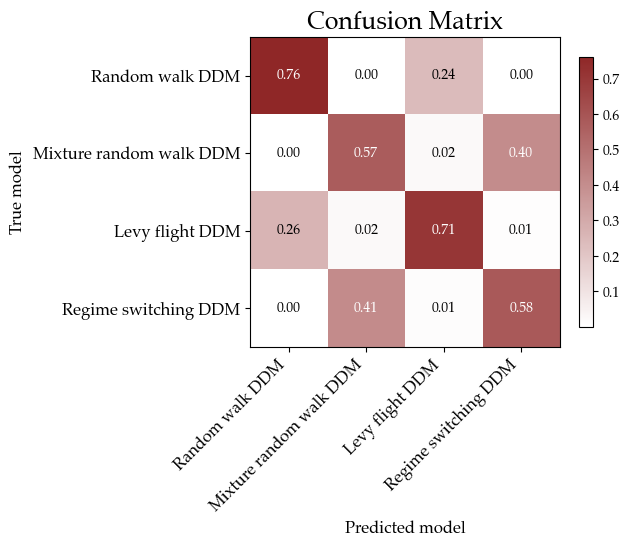

In [57]:
confusion_matrix = beef.diagnostics.plot_confusion_matrix(
    model_indices,
    model_probs,
    xtick_rotation=45,
    ytick_rotation=0,
    model_names=MODEL_NAMES,
    # fig_size=(8, 8),
    # title_fontsize=22,
    # label_fontsize=20,
    # tick_fontsize=18,
    # legend_fontsize=18
)

confusion_matrix.savefig("../plots/confusion_matrix.pdf", dpi=300, bbox_inches="tight")

In [ ]:
np.mean(abs(model_indices - model_probs))

In [ ]:
from sklearn.metrics import log_loss
log_loss(model_indices, model_probs)